## 要正確執行需要以下檔案在目前目錄底下
* baseline.pt
* train.csv
* test.csv

In [ ]:
train_path = "/kaggle/input/fast-using-lstm-model-steps/train.csv"
test_path = "/kaggle/input/fast-using-lstm-model-steps/test.csv"
model_path = '/kaggle/input/fast-using-lstm-model-steps/model.pt'

In [ ]:
!pip install torchtext==0.6.0
!python -m spacy download en_core_web_sm
import pandas as pd
import numpy as np
from torchtext import data
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay  # new version of plot_confusion_matrix
import seaborn as sns


In [ ]:
TEXT = data.Field(sequential=True, tokenize="spacy", tokenizer_language="en_core_web_sm", lower=True, include_lengths=True) # new tokenizer_language to fit new model
SCORE = data.Field(sequential=False, use_vocab=False)
datafields = [("text", TEXT), ("Author_num", SCORE)]

train= data.TabularDataset(
    path=train_path,
    format='csv',fields=datafields,skip_header = True)
val = data.TabularDataset(
    path=test_path,
    format='csv',fields=datafields,skip_header = True)

from torchtext import vocab
from torchtext.vocab import GloVe
TEXT.build_vocab(train, val, min_freq = 3, vectors=GloVe(name='6B', dim=100))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # choose device according to hardware support


In [ ]:
type(TEXT)

# load model
## 請看"修改部分"，這決定你輸入文章後會印出甚麼

In [ ]:
class AuthorClassifier(nn.Module):

    def __init__(self, mode, output_size, hidden_size, vocab_size, embedding_length, word_embeddings):
        super(AuthorClassifier, self).__init__()

        if mode not in ['rnn', 'lstm', 'gru', 'bilstm']:
            raise ValueError("Choose a mode from - rnn / lstm / gru / bilstm")

        self.mode = mode
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.embedding = nn.Embedding(self.vocab_size,self.embedding_length)
        self.embedding.weight = nn.Parameter(word_embeddings,requires_grad = False)

        if self.mode == 'rnn':
            self.network = nn.RNN(self.embedding_length,self.hidden_size)
        elif self.mode == 'lstm':
            self.network = nn.LSTM(self.embedding_length,self.hidden_size)
        elif self.mode == 'gru':
            self.network = nn.GRU(self.embedding_length,self.hidden_size)
        elif self.mode == 'bilstm':
            self.network = nn.LSTM(self.embedding_length,self.hidden_size,bidirectional = True)


        self.fclayer = nn.Linear(self.hidden_size,self.output_size)


    def forward(self, text, text_lengths):
        text_embeddings = self.embedding(text)
        pack_sequence = nn.utils.rnn.pack_padded_sequence(text_embeddings,text_lengths.cpu()) # lengths.cpu() for matching new input format

        if self.mode in ('lstm', 'bilstm'):
            _, (hidden, cell) = self.network(pack_sequence)
            if self.mode == 'bilstm':
                hidden = hidden[0,:,:] + hidden[1,:,:]
        else:
            _, hidden = self.network(pack_sequence)
        
        hidden = hidden.squeeze(0)
        pred = self.fclayer(hidden)
        return pred

def evaluate_classifier(model, dataset_iterator, loss_function, recurrent = True):
    model.eval()

    correct = 0
    total = 0
    total_loss = 0
    overall_pred = []
    overall_label = []
    accuracy_test = []
    loss_test = []
    f1_step = 0
    f1 = 0

    for batch in dataset_iterator:
        comment, comment_lengths = batch.text
        labels = batch.Author_num   # tag of author number
        
        # ---------修改部分---------#
        # output是dense層的輸出，但還未經過最後一層activation層(softmax)
        output = model(comment, comment_lengths).squeeze(0)
        
        # 所以這裡額外新增一個softmax層計算，結果就會是對50位作者的機率，機率和為1。
        softmax = F.softmax(output, dim=1)
        
        # 這裡的data[0]指的是該batch中的第一筆資料
#         print(softmax.data[0])
        
        # 這裡找出機率最大的，代表模型判斷結果
#         print("result:")
#         print(torch.max(output.data,1).indices.tolist())
        
        # prediction will be the values in each row
        # they represent the possibility(weight) of an article which belongs to jth author(in jth row)
        # ---------修改部分---------#

        loss = loss_function(output, labels.long()) # .long means .to(torch.int64)
        pred = torch.max(output.data,1).indices
        correct += (torch.sum(pred == labels)).item()
        total += len(labels)
        total_loss += loss.item()
        ap = pred.cpu()
        a = np.asarray(ap)
        labels = labels.cpu()
        b = np.asarray(labels)
        f1_step += 1
        overall_pred.append(a)
        overall_label.append(b)

    overall_p = [val for sublist in overall_pred for val in sublist]
    overall_l = [val for sublist in overall_label for val in sublist]
    f1ss = sklearn.metrics.f1_score(overall_l,overall_p,average= 'macro')
    accuracy_test.append(correct/total)
    loss_test.append(total_loss/total)
    print("Validation statistics: Acc: %s Loss: %s"%(correct/total, total_loss/total),'F1 Score:',f1ss)
    return overall_pred,overall_label,accuracy_test,f1ss,loss_test, torch.max(output.data,1).indices.tolist()

In [ ]:
model = torch.load(model_path)
loss_function = nn.CrossEntropyLoss()

## 以下才是真正使用的部分：兩者只需要挑一種
* 如果要從train/test裡面用切出幾篇文章的作法
* 直接輸入文章的做法

In [ ]:
#方法一
#-------從train載入可以用切片-------
train_examples = [example for example in train]

# 最后，使用切片操作获取前1000个样本
train_subset = train_examples[:2]

# 如果你需要将这1000个样本再转换回TabularDataset，你可能需要创建一个新的Dataset
train_subset_dataset = data.Dataset(train_subset, fields=datafields)
#-------從train載入可以用切片-------
articles_word_grad_test_Iterator = data.BucketIterator(
    train_subset_dataset,
    batch_size = 2,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=True,
    device = device)
_ = evaluate_classifier(model, articles_word_grad_test_Iterator, loss_function)

In [ ]:
df_train = pd.read_csv(train_path)

In [ ]:
#方法二

#----------你需要修改-----------#
my_article_df = pd.DataFrame({
    'text' : ['This is article one.', df_train['text'][1]],
    'Author_num' : [0, 0]
})
#----------你需要修改-----------#

my_article_df.to_csv('tmp.csv', index=False)

# 轉換成Dataset
dataset = data.TabularDataset(
    path='tmp.csv',
    format='csv',fields=datafields,skip_header = True)

articles_word_grad_test_Iterator = data.BucketIterator(
    dataset,
    batch_size = 2,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=True,
    device = device)
_ = evaluate_classifier(model, articles_word_grad_test_Iterator, loss_function)

In [ ]:
def classify(article1, article2, author1, author2):
    assert type(article1) == str
    assert type(article2) == str
    assert type(author1) == int
    assert type(author2) == int
    
    my_article_df = pd.DataFrame({
    'text' : [article1, article2],
    'Author_num' : [author1, author2]
    })
    my_article_df.to_csv('tmp.csv', index=False)
    
    # 轉換成Dataset
    dataset = data.TabularDataset(
        path='tmp.csv',
        format='csv',fields=datafields,skip_header = True)

    articles_word_grad_test_Iterator = data.BucketIterator(
        dataset,
        batch_size = 2,
        sort_key = lambda x: len(x.text),
        sort_within_batch = True,
        repeat=False,
        shuffle=True,
        device = device)
    res = evaluate_classifier(model, articles_word_grad_test_Iterator, loss_function)
    res = res[4]


# 原本辨別器的輸出結果

In [ ]:
BATCH_SIZE = 64
train_iterator = data.BucketIterator(
    train,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text), # 使每個batch裡面的文章長度相近
    sort_within_batch = True,      # 用於RNN like模型，提高訓練效率
    repeat=False,             # true就會不斷產生batch
    shuffle=True,             # 打亂batch之間的順序
    device = device)

val_iterator = data.BucketIterator(
    val,
    batch_size = BATCH_SIZE,
    sort=False,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    repeat=False,
    shuffle=False,
    device = device)


In [ ]:
plt.figure(figsize=(15, 15))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
log_dir = 'runs/lstm1'
final_acc_train_lstm  = []
final_loss_train_lstm = []
final_loss_test_lstm = []
final_acc_test_lstm = []
final_f1score_train_lstm = []
final_f1score_test_lstm = []

overall_pred,overall_label,accs_test,f1ss,loss_test, _ = evaluate_classifier(model, val_iterator, loss_function)
final_acc_test_lstm.append(accs_test[0])
final_f1score_test_lstm.append(f1ss)
final_loss_test_lstm.append(loss_test[0])

cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
    cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)

## phase 1 混淆

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
similarity_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
import re
import nltk
from nltk.tokenize import word_tokenize
# 下载所需的数据集和模型
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from tqdm import tqdm

In [18]:
import json
# 打开之前保存的 JSON 文件
with open('/kaggle/input/fast-using-lstm-model-steps/data.json', 'r', encoding='utf-8') as file:
    # 使用 json.load 方法从文件中读取数据
    word_list = json.load(file)

In [19]:
df_train = pd.read_csv(train_path)

In [ ]:
# 定义两篇文章
article1 = df_train['text'][0]
article2 = df_train['text'][0]

# 分割并清理文章
sentences1 = split_and_clean(article1)
sentences2 = split_and_clean(article2)
sentences1 , _= replace_word_in_text(sentences1, word_list[0])
# sentences2 = replace_word_in_text(sentences2, word_list[0])
for s in sentences1:
    print(s)
# for idx in range(len(sentences1)):
#     print(sentences1[idx] == sentences2[idx])

In [ ]:
# 一次性编码所有句子
embeddings1 = similarity_model.encode(sentences1, convert_to_tensor=True)
embeddings2 = similarity_model.encode(sentences2, convert_to_tensor=True)

# 计算句子相似度并求平均值
total_similarity = 0
for idx in range(len(embeddings1)):
    cosine_similarity = util.pytorch_cos_sim(embeddings1[idx], embeddings2[idx])
    total_similarity += cosine_similarity.item()
average_similarity = total_similarity / len(sentences1)
# 计算平均相似度
# average_similarity = total_similarity / (len(sentences1) * len(sentences2)) if sentences1 and sentences2 else 0

print("文章的平均相似度:", average_similarity)

In [58]:
def similarity(embeddings1, embeddings2):
    assert len(embeddings1) == len(embeddings2)
    total_similarity = 0
    for idx in range(len(embeddings1)):
        cosine_similarity = util.pytorch_cos_sim(embeddings1[idx], embeddings2[idx])
        total_similarity += cosine_similarity.item()
    return total_similarity / len(embeddings1)
    
def replace_word_in_text(article, words_to_replace, article_num=0, pri = 0):
    # article = [sen1, sen2, ...]
    assert type(article) == list
    
    # 使用字符串的 replace 方法替换所有出现的指定单词
    new_art = []
    total_change = 0
    for sentence in article:
        
        for old_word in words_to_replace.keys():
            count = sentence.count(old_word)
            sentence = sentence.replace(old_word, old_word+"NMSL")
            total_change += count
        new_art.append(sentence)
    if pri: print(f"Changed {total_change} in article {article_num}.")
    return new_art, total_change

# 函数：分割文章为句子并清理特殊字符
def split_and_clean(text):
    # 分割文章为句子
    sentences = re.split(r'\r\n', text)
    # 清理每个句子
#     cleaned_sentences = [re.sub(r'[^\w\s]', '', s) for s in sentences]
    return sentences

def POS_replace(article, mode=1, idx=0, pri=0):
    match mode:
        case 1: # 一般N
            pos = {'NN', 'NNS'}
            
        case 2: # 專有N
            pos = {'NNP', 'NNPS'}
            
        case 3: # 動詞
            pos = {'VB', 'VBD', 'VBG','VBN', 'VBP', 'MD'}
        
        case 4: # adj
            pos = {'JJ', 'JJR', 'JJS'}
        
        case 5: # 人稱代詞  物主代词
            pos = {'PRP', 'PRP$'}
        
        case 6: # 副詞
            pos = {'RB', 'RBR', 'RBS'}
        
        case 7: # else
            pos = {'DT', 'CC', 'IN', 'MD', 'CD'}
            
        case 8: # 所有名詞
            pos = {'NN', 'NNS', 'NNP', 'NNPS'}
            
        case _:
            pos = {
                'NN', 'NNS', 'NNP', 'NNPS',
                'PRP', 'PRP$', 'RB', 'RBR',
                'RBS', 'VB', 'VBD', 'VBG',
                'VBN', 'VBP', 'VBZ', 'JJ',
                'JJR', 'JJS', 'DT', 'CC',
                'IN', 'MD', 'CD'
            }
            
    # article = [sen1, sen2, ...]
    assert type(article) == list
    
    new_art = []
    total_change = 0
    for sentence in article:
        # 词性标注
        words = word_tokenize(sentence)
        pos_tags = nltk.pos_tag(words)

        # 換字
        words_to_replace = [i[0] for i in pos_tags if i[1] in pos]
        for old_word in words_to_replace:
            count = sentence.count(old_word)
            sentence = sentence.replace(old_word, old_word+"NMSL")
            total_change += count
        
        # 保存
        new_art.append(sentence)
    
    if pri: print(f"Changed {total_change} in article {idx}.")
    return new_art, total_change



In [ ]:
original_articles_embeddings = []
for article in df_train['text']:
    original_articles_embeddings.append(similarity_model.encode(split_and_clean(article), convert_to_tensor=True, batch_size = 64, show_progress_bar = False))

# 計算去掉特殊字元後的原本資料集

changing words…: 100%|██████████████████████████████████████████| 4000/4000 [02:31<00:00, 26.45it/s]


total changed 1669010 words, 417.2525 per article
Validation statistics: Acc: 0.29925 Loss: 0.06312596064805985 F1 Score: 0.3058628235866624


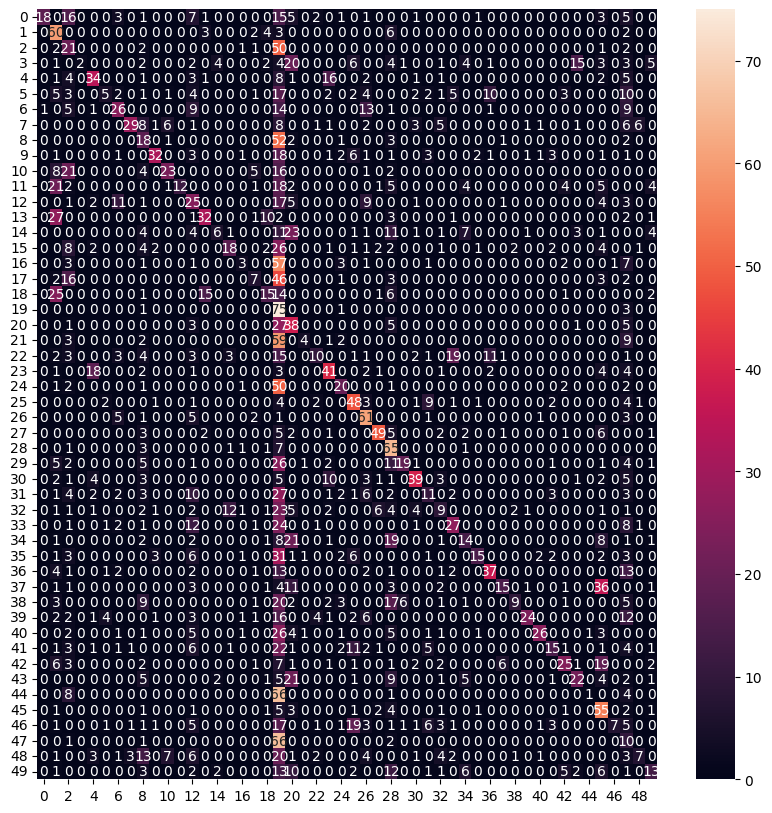

In [59]:
df_train_afterSentenceSplit = pd.read_csv(train_path)
total_change_amount=0
articles = []
for idx in tqdm (range(len(df_train_afterSentenceSplit)) , desc="changing words…", ascii=False, ncols=100):
    article = split_and_clean(df_train_afterSentenceSplit['text'][idx])
    # [方法一]根據IFIDF找字，換字方法是直接破壞那個字
#     article, amount= replace_word_in_text(article, word_list[df_train_afterSentenceSplit['Author_num'][idx]], idx, 0)
#     total_change_amount+=amount
    
    # [方法二]根據詞性
    article, amount= POS_replace(article, mode=7,idx=idx, pri=0)
    total_change_amount+=amount
    
    # 維持原樣，正確率97%, f1也是97%
#     article = ''.join(article)
    
    # save for testing similarity
    articles.append(article)
    
    df_train_afterSentenceSplit.loc[idx, 'text'] = ''.join(article)

print(f"total changed {total_change_amount} words, {total_change_amount/len(df_train_afterSentenceSplit)} per article")
df_train_afterSentenceSplit.to_csv('df_train_afterSentenceSplit.csv', index=False)

train_afterSentenceSplit = data.TabularDataset(
    path='df_train_afterSentenceSplit.csv',
    format='csv',fields=datafields,skip_header = True)

train_afterSentenceSplit_iterator = data.BucketIterator(
    train_afterSentenceSplit,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text), # 使每個batch裡面的文章長度相近
    sort_within_batch = True,      # 用於RNN like模型，提高訓練效率
    repeat=False,             # true就會不斷產生batch
    shuffle=True,             # 打亂batch之間的順序
    device = device)

plt.figure(figsize=(10, 10))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
final_acc_train_lstm  = []
final_loss_train_lstm = []
final_loss_test_lstm = []
final_acc_test_lstm = []
final_f1score_train_lstm = []
final_f1score_test_lstm = []

overall_pred,overall_label,accs_test,f1ss,loss_test, _ = evaluate_classifier(model, train_afterSentenceSplit_iterator, loss_function)
final_acc_test_lstm.append(accs_test[0])
final_f1score_test_lstm.append(f1ss)
final_loss_test_lstm.append(loss_test[0])

cf = np.zeros((50,50))

overall_pred = [val for sublist in overall_pred for val in sublist]

overall_label = [val for sublist in overall_label for val in sublist]

ziplist = list(zip(overall_label,overall_pred))
for coordinate in ziplist:
    cf[coordinate]+=1
ax = sns.heatmap(cf,annot=True)



In [60]:
# similarity test
# compute new_artical_embeddings
new_artical_embeddings = []
for i in tqdm (range (len(articles)), desc="computing new_artical_embeddings…", ascii=False, ncols=100):
    new_artical_embeddings.append(similarity_model.encode(articles[i], convert_to_tensor=True, batch_size = 64, show_progress_bar = False))

artical_similarity = []
avg_s = 0
for idx in tqdm (range(len(df_train)), desc="computing similarity…", ascii=False, ncols=100):
    s = similarity(original_articles_embeddings[idx], new_artical_embeddings[idx])
    avg_s += s
#     print(f"article {idx} similarity = {s}")
print(f"total articles avg. similarity = {avg_s/len(df_train)}")

computing similarity…: 100%|███████████████████████████████████| 4000/4000 [00:12<00:00, 325.03it/s]

total articles avg. similarity = 0.6128761924746623
